# Mini-project I: Parameter estimation for a toy model of an EFT

The overall project goal is to reproduce various results in this paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618).  It's a long paper, so don't try to read all of it!  (At least not now.)  We'll guide you to the relevant parts.

The paper uses toy models for effective field theories, namely Taylor series of some specified functions, to present guidelines for parameter estimation. This will also be a check of whether you can follow (or give you practice on) Bayesian statistics discussions in the physics literature.

You'll find summaries in section II that touch on topics we have discussed and will discuss.  The function
$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$
represents the true, underlying theory.  It has a Taylor expansion
$$
g(x) = 0.25 + 1.57x + 2.47x^2 + 1.29 x^3 + \cdots
$$
Our model for an EFT for this "theory" is
$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i
$$
and your general task is to fit 1, 2, 3, ... of the constants $a_i$, and analyze the results.
**Your primary goal is to reproduce and interpret Table III on page 12 of the arXiv preprint.  A secondary goal is to reproduce Figure 1 of the same paper.**  You should use the emcee sampler and corner to make plots.

<div style="float:center;"><img src="summary_of_project.png" width=700px></div>


### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the notebooks [Gaussian noise](https://github.com/furnstahl/Physics-8805/blob/master/topics/bayesian-parameter-estimation/parameter_estimation_Gaussian_noise.ipynb) and [Fitting a straight line II [ipynb]](https://github.com/NuclearTalent/Bayes2019/blob/master/topics/why-bayes-is-better/parameter_estimation_fitting_straight_line_II.ipynb).
* Define a function for the exact result plus noise, noting from the arXiv paper what type of noise is added and where the points are located (i.e., what values of $x$). 
* Define functions for the two choices of prior and for the likelihood.
* Call emcee to sample the posteriors.
* Use corner to create plots.  You can read the answers for the tables from the corner plots.
* Don't try to do too much in your code at first (start with the lowest order in Table III). 
* Fill in the rest of Table III.
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.


### Comments and suggestions
* The 5% error is a *relative* error, meaning it is 0.05 times the data at that point.  This means if you generate a Gaussian random number `err` distributed with standard deviation 0.05, the value of sigma for the log likelihood is `sigma[i] = data[i] * err` (use the data, not the theory at `i`).
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(samples, [16, 50, 84],axis=0)` might be useful to extract numerical values for the credibility region and the mean from a python array `samples`of shape (nsamples,ndimensions).
* The example on [Fitting a Model to Data](https://emcee.readthedocs.io/en/v2.2.1/user/line/) from the emcee documentation may be useful to supplement the examples in the TALENT notebooks.

### Additional subtasks 
* Reproduce Figures 3 and 4, showing the predictions with error bands for the two priors compared to the true function.  You can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)
* Reproduce Figures 5 (alternative prior and "returning the prior"), 6 (posterior for $\overline a$), and 7 ("relaxing to least squares").  
* Reproduce Figure 9 (sensitivity to choice of $x_{\rm max}$)
* Repeat analysis with same function but different data precision and/or quantity (number of data points).
* Repeat analysis with a different function from the paper or invent your own function and analyze.


# Python imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting
import scipy.stats as stats

from cycler import cycler
from matplotlib.cm import get_cmap

import emcee  # MCMC sampler
print('emcee sampling (version: )', emcee.__version__)

import corner  # to make projected posterior plots


emcee sampling (version: ) 2.2.1


## The Data and the true result

Let's start by defining the exact function and the data for the toy model.

In [2]:
def g_fun(x):
    """
    Toy function to model an EFT expansion.  It has a Taylor expansion about
    x=0 with a radius of convergence of 1.
    """
    return (0.5 + np.tan(np.pi * x / 2.))**2

In [3]:
def y_model(x_pts, theta, orders=None):
    """
    Returns the evaluation of the theoretical model at all x values in the
    numpy array x_pts, using coefficients from theta, where orders is the
    number of coefficients to use (if orders is not specified in the call
    to y_model, it is assigned None and this means to use all the coefficients 
    in theta).
    
    The theoretical model is (with n = orders - 1):
      y_model(x) = theta_0 + theta_1 * x + ... + theta_n * x**n
                 = \sum_{i=0}^{orders} theta_i x^i
                 
    This is cleanly implemented using a nested list comprehension.             
    """
    
    if orders is None:   # use the full theta vector
        orders = len(theta)
    
    return np.array( [ np.sum(
                               [theta[i] * x**i for i in range(orders)]
                             ) for x in x_pts ] )
    

In generating the data points, we have to keep in mind that the errors are *relative* errors, so the 5% uncertainty is multiplied by the data at each $x$.

In [4]:
# Generate data points as described in the paper arXiv:1511.03618
x_max = 1. / np.pi   # we'll eventually need to test sensitivity to x_max
x_data_pts = np.linspace(x_max/10., x_max, 10) # don't start at x=0
eta = 0.05         # specified relative uncertainty is 5%
y_data_pts = g_fun(x_data_pts) * \
                  (1. + stats.norm.rvs(0., eta, size=len(x_data_pts)) )
dy_data = eta * y_data_pts


The files for arXiv:1511.03618 also include a data file with the actual x and y data points used.  To precisely reproduce the figures and table we should use those, but also check that new randomly generated 

D1_c_5.dat: Used to generate results in Table III

| x		|	data	|	sigma   |
| :---: | :-----: | :-----:  |
|0.03183	| 0.31694	| 0.01585
|0.06366	| 0.33844	| 0.01692
|0.09549	| 0.42142	| 0.02107
|0.12732	| 0.57709	| 0.02885
|0.15915	| 0.56218	| 0.02811
|0.19099	| 0.68851	| 0.03443
|0.22282	| 0.73625	| 0.03681
|0.25465	| 0.87270	| 0.04364
|0.28648	| 1.0015	| 0.050075
|0.31831	| 1.0684	| 0.05342

In [5]:
# x, y, and dy from D1_c_5.dat, used to generate Table III
x_data_pts_paper = np.array([0.03183, 0.06366, 0.09549, 0.12732, 0.15915,
                             0.19099, 0.22282, 0.25465, 0.28648, 0.31831])

y_data_pts_paper = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218,
                             0.68851, 0.73625, 0.87270, 1.00150, 1.06840])

dy_data_paper = np.array([0.01585, 0.01692, 0.02107, 0.02885, 0.02811,
                          0.03443, 0.03681, 0.04364, 0.050075, 0.05342])

# For now make these the ones we analyze
x_data_pts = x_data_pts_paper
y_data_pts = y_data_pts_paper
dy_data = dy_data_paper

Always make a figure to check your data!

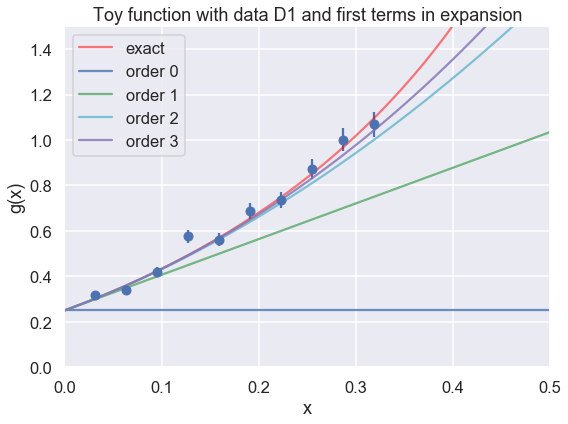

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x_data_pts, y_data_pts, dy_data, fmt='o')
ax.set_xlabel(r'x')
ax.set_ylabel(r'g(x)')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1.5)

x_pts_all = np.arange(0., 1., .01)
ax.plot(x_pts_all, g_fun(x_pts_all), color='red', alpha=0.5, label='exact')
ax.set_title('Toy function with data D1 and first terms in expansion')

theta_true = np.array([0.25, 1.5707963, 2.4674011, 1.2919282, 4.0587121,
                       1.275082, 5.67486677])
colors = ['b', 'g', 'c', 'm', 'k', 'r', 'b']

n_dim = 4
for order in range(n_dim):
    ax.plot(x_pts_all, y_model(x_pts_all, theta_true[:n_dim], order+1), 
            label=f'order {order:d}', color=colors[order], alpha=0.8)

ax.legend()


fig.tight_layout()

When using the data from the paper, this does look like the figure above.

## The Model

We follow the procedure outlined in [parameter_estimation_fitting_straight_line_I.ipynb](../bayesian-parameter-estimation/parameter_estimation_fitting_straight_line_I.ipynb) and other notebooks for using emcee to sample from a posterior.

Here we are given data with simple error bars, which imply that the probability for any *single* data point is a normal distribution about the true value. That is,
$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \varepsilon_i)
$$
or, in other words,
$$
p(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\varepsilon_i^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\varepsilon_i^2}\right)
$$
where $\varepsilon_i$ are the (known) measurement errors indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:
$$
p(D\mid\theta) = \prod_{i=1}^N p(x_i,y_i | \theta)
$$
For convenience and numerical accuracy, this is usually expressed in terms of the log-likelihood:
$$
\log p(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

In [7]:
def log_likelihood(x_data, y_data, dy, theta):
    """
    Define the log likelihood according to the equations above.  theta is a
    vector of coefficient of the expansion.
    """
    y_th = y_model(x_data, theta)
    
    return -0.5 * np.sum( np.log(2 * np.pi * dy ** 2) +
                          (y_data - y_th) ** 2 / dy ** 2
                        )

def log_uniform_prior(theta, a_max=500.):
    """
    Return 0 (= log 1, so unnormalized) if all parameters are less than 
    a_max in absolute value, otherwise return -inf (= log 0). 
    """
    if np.logical_and(-a_max <= theta, theta <= a_max).all(): 
        return 0
    else:
        return -np.inf

def log_gaussian_prior(theta, a_bar=5.):
    """
    Return a gaussian with width a_bar (normalized).  Default a_bar=5.
    """
    return -0.5 * np.sum( np.log(2 * np.pi * a_bar ** 2) +
                          theta ** 2 / a_bar ** 2
                        )

def log_posterior(theta, x_data, y_data, dy, log_prior=log_gaussian_prior):
    return log_prior(theta) + log_likelihood(x_data, y_data, dy, theta)



Always check that your functions do what you expect: do *not* assume that they work just from reading the code.  It is a good idea to do some sample plots.

## Results

In [8]:

def sample_posterior(n_dim, log_prior, silent=False):
    """
    Sample the posterior using emcee.  The number of walkers, burn-in and
    post-burn-in steps per walker are hardwired in this function.
    """
    
    n_walkers = 50  # number of MCMC walkers
    n_burn = 1000  # "burn-in" period to let chains stabilize
    n_steps = 2000 # steps per walker
    
    #print(f'{n_walkers} walkers: {n_steps} samples each')
    
    # Initialize walkers: for each of the n_walkers, we have n_dim 
    #  initializations.  Here: initialize using normal distribution with mean 
    #  zero and standard deviation starting_sd
    starting_sd = 2.
    starting_guesses = starting_sd * np.random.randn(n_walkers, n_dim)
    
    # sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
    #                                 args=[x_data_pts, y_data_pts, dy_data,
    #                                       log_gaussian_prior])
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                    args=[x_data_pts, y_data_pts, dy_data,
                                          log_prior])
    
    # "burn-in" period; save final positions and then reset
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_burn)
    sampler.reset()
    
    # sampling period
    sampler.run_mcmc(pos, n_steps)
    
    if (not silent):
        print(f'Mean acceptance fraction: ',
              f'{np.mean(sampler.acceptance_fraction):.3f}',
              f'(in total {n_walkers * n_steps:d} steps)')
    
    # Discard burn-in points and flatten the walkers; 
    #  the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, n_dim))
    
    return samples, starting_guesses, sampler
    


In [9]:
def starting_guesses_histogram(starting_guesses):
    # quick histogram of the starting guesses
    plt.hist(starting_guesses.flatten(), range=(-5,5), bins=21,
             histtype='stepfilled', density=True,  alpha=0.5, 
             );

In [10]:
def trace_plots(n_dim, sampler):
    fig, ax = plt.subplots(n_dim, sharex=True, figsize=(10,12))
    for i in range(n_dim):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.1)
        ax[i].set_ylabel(rf'$a_{i:d}$')
        
    ax[-1].set_xlabel('step # after warm-up')    
    fig.tight_layout()

In [11]:
def corner_plot(n_dim, samples, theta_true):
    # make a corner plot with the posterior distribution
    corner_labels = [rf'$a_{i:d}$' for i in range(n_dim)]
    fig = corner.corner(samples, labels=corner_labels, 
                        truths=theta_true[:n_dim], quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 15})


In [12]:
from IPython.display import display, Math

def emcee_quantiles(n_dim, samples):
    """
    Return the result for 50% minus 16% plus 84% (so "one sigma").
    Probably can do this efficiently with list comprehensions!
    """
    plus = np.zeros(n_dim)
    minus = np.zeros(n_dim)
    central = np.zeros(n_dim)
    for i in range(n_dim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        minus[i], plus[i]  = np.diff(mcmc)
        central[i] = mcmc[1]
    return central, plus, minus


Mean acceptance fraction:  0.595 (in total 100000 steps)


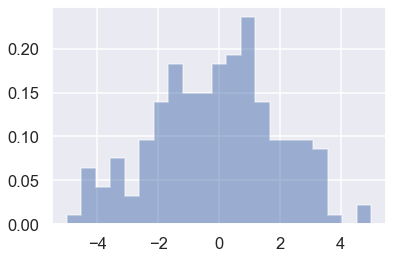

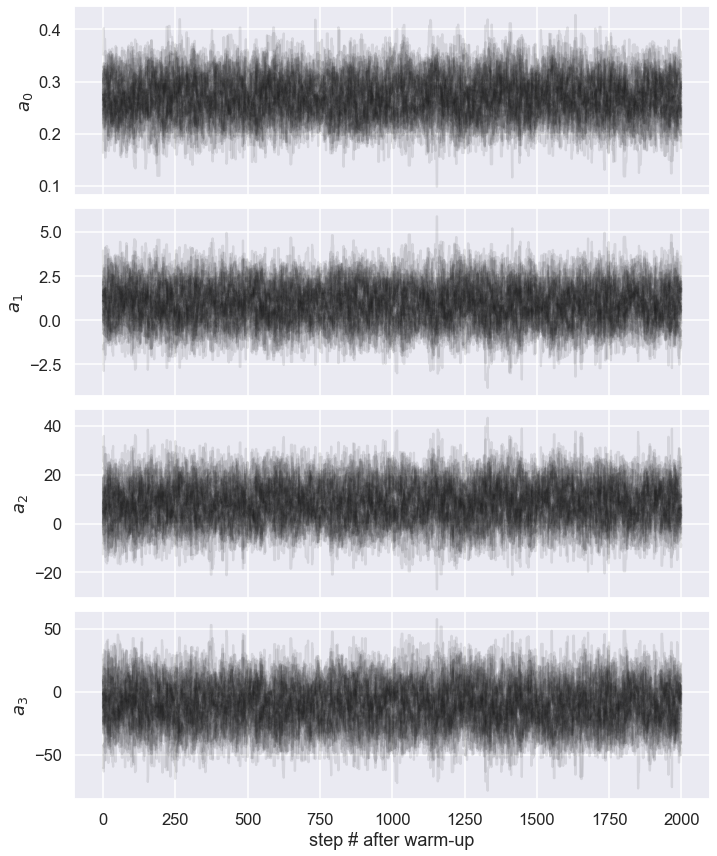

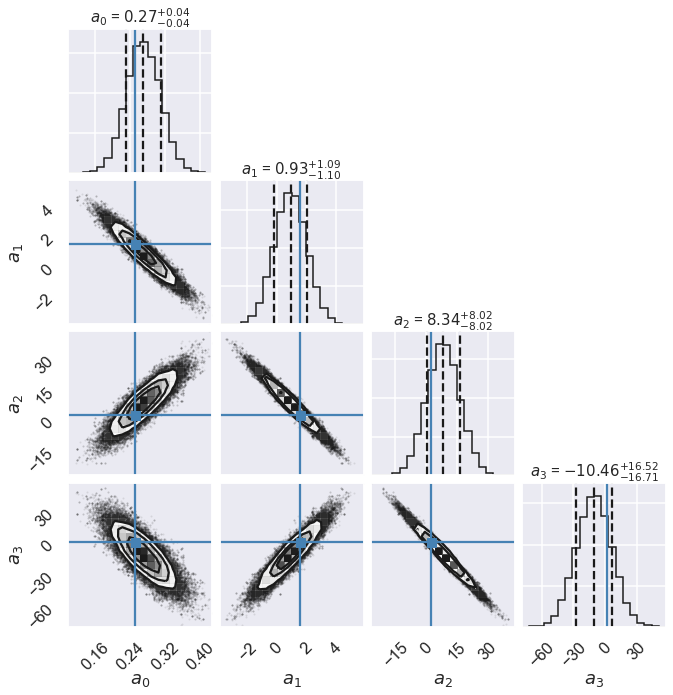

In [13]:
# Figure 1 in arXiv:1511.03618, uniform prior

n_dim = 4

# Generate samples
samples, start_guesses, sampler = sample_posterior(n_dim, log_uniform_prior) 

# Check the histogram of starting values
starting_guesses_histogram(start_guesses)   

# Look at the traces for each coefficient
trace_plots(n_dim, sampler)

# Make the corner plot
corner_plot(n_dim, samples, theta_true)

Mean acceptance fraction:  0.591 (in total 100000 steps)


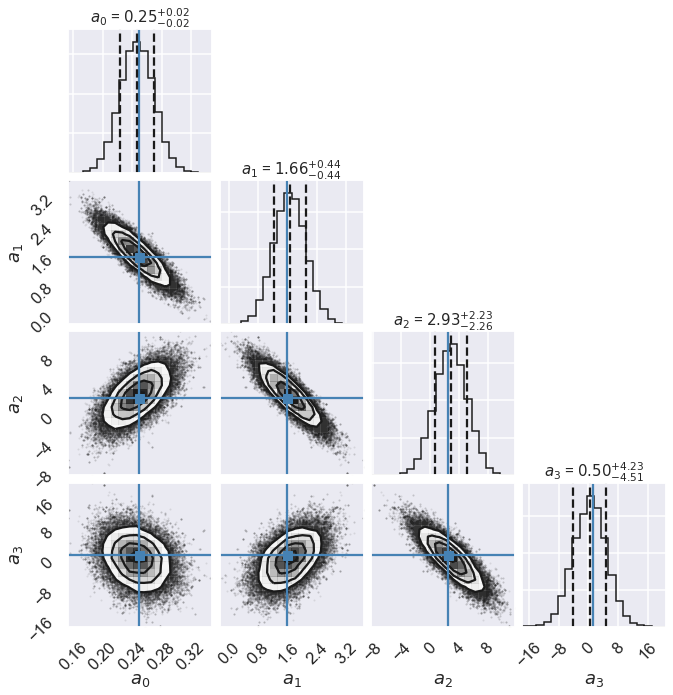

In [14]:
# Figure 1 in arXiv:1511.03618, Naturalness (gaussian) prior

n_dim = 4

# Generate samples
samples, start_guesses, sampler = sample_posterior(n_dim, log_gaussian_prior) 

# Check the histogram of starting values
#starting_guesses_histogram(start_guesses)   

# Look at the traces for each coefficient
#trace_plots(n_dim, sampler)

# Make the corner plot
corner_plot(n_dim, samples, theta_true)

Now generate the results in Table III from arXiv:1511.03618

In [15]:
# First uniform prior
print('              Uniform prior  ')
print(' k_max       a_0            a_1            a_2            a_3')
for n_dim in np.arange(1,8):
    # Generate samples
    samples, dum1, dum2 = sample_posterior(n_dim, log_uniform_prior,
                                           silent=True) 
    central, plus, minus = emcee_quantiles(n_dim, samples)
    print(f'   {n_dim - 1:d}    ', end='')
    for i in np.arange(n_dim):
        if (i > 3):
            break
        print(f'{central[i]:.2f}+{plus[i]:.2f}-{minus[i]:.2f} ', end='')
    print()

    
# Next Gaussian (aturalness) prior
print(' ')
print('             Gaussian prior  ')
print(' k_max       a_0            a_1            a_2            a_3')
for n_dim in np.arange(1,8):
    # Generate samples
    samples, dum1, dum2 = sample_posterior(n_dim, log_gaussian_prior, 
                                           silent=True) 
    central, plus, minus = emcee_quantiles(n_dim, samples)
    print(f'   {n_dim - 1:d}    ', end='')
    for i in np.arange(n_dim):
        if (i > 3):
            break
        print(f'{central[i]:.2f}+{plus[i]:.2f}-{minus[i]:.2f} ', end='')
    print()


              Uniform prior  
 k_max       a_0            a_1            a_2            a_3
   0    0.48+0.01-0.01 
   1    0.20+0.01-0.01 2.55+0.10-0.10 
   2    0.25+0.02-0.02 1.58+0.40-0.41 3.29+1.32-1.31 
   3    0.27+0.04-0.04 0.95+1.11-1.09 8.12+8.08-8.17 -10.05+16.99-16.67 
   4    0.32+0.06-0.06 -1.41+2.52-2.08 38.30+24.91-30.04 -151.18+136.90-115.56 
   5    0.31+0.06-0.06 -1.09+2.35-2.27 34.68+25.51-27.96 -136.97+135.16-108.83 
   6    0.31+0.06-0.06 -0.90+2.21-2.25 32.61+25.61-27.79 -127.27+139.64-109.86 
 
             Gaussian prior  
 k_max       a_0            a_1            a_2            a_3
   0    0.48+0.01-0.01 
   1    0.20+0.01-0.01 2.55+0.11-0.10 
   2    0.25+0.02-0.02 1.62+0.40-0.39 3.16+1.27-1.31 
   3    0.25+0.02-0.02 1.63+0.44-0.45 3.08+2.28-2.31 0.20+4.50-4.28 
   4    0.25+0.02-0.02 1.65+0.46-0.45 2.98+2.37-2.36 0.33+4.34-4.43 
   5    0.25+0.02-0.02 1.62+0.47-0.45 3.20+2.33-2.41 -0.04+4.47-4.22 
   6    0.25+0.02-0.02 1.64+0.45-0.44 2.98+2.35-2.30 0.38+4